In [1]:
!pip install -q pytorchvideo transformers evaluate


In [1]:
from huggingface_hub import hf_hub_download
hf_dataset_identifier = "sayakpaul/ucf101-subset"

filename = "UCF101_subset.tar.gz"

file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

/home/gea/anaconda3/envs/torchvision/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tarfile

with tarfile.open(file_path) as t:

     t.extractall(".")

In [3]:
import os
all_video_file_paths = os.listdir('UCF101_subset/train')
all_video_file_paths

['BalanceBeam',
 'ApplyLipstick',
 'BasketballDunk',
 'BenchPress',
 'ApplyEyeMakeup',
 'BabyCrawling',
 'BaseballPitch',
 'Basketball',
 'BandMarching',
 'Archery']

In [4]:
label2id = {label: i for i, label in enumerate(all_video_file_paths)}

id2label = {i: label for label, i in label2id.items()}
label2id, id2label

({'BalanceBeam': 0,
  'ApplyLipstick': 1,
  'BasketballDunk': 2,
  'BenchPress': 3,
  'ApplyEyeMakeup': 4,
  'BabyCrawling': 5,
  'BaseballPitch': 6,
  'Basketball': 7,
  'BandMarching': 8,
  'Archery': 9},
 {0: 'BalanceBeam',
  1: 'ApplyLipstick',
  2: 'BasketballDunk',
  3: 'BenchPress',
  4: 'ApplyEyeMakeup',
  5: 'BabyCrawling',
  6: 'BaseballPitch',
  7: 'Basketball',
  8: 'BandMarching',
  9: 'Archery'})

In [5]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

/home/gea/anaconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [7]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)
num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [8]:
train_transform = Compose(
    [ApplyTransformToKey(
            key="video",
            transform=Compose(
                [UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),]),),])

In [9]:
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join('UCF101_subset/', "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [10]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join('UCF101_subset/', "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join('UCF101_subset/', "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [11]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

300 30 75


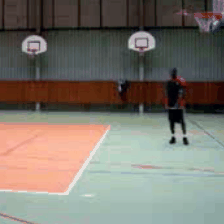

In [12]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [19]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4
batch_size = 128

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'is_fairscale_available' from 'transformers.integrations' (/home/gea/anaconda3/envs/torchvision/lib/python3.11/site-packages/transformers/integrations/__init__.py)